### 🤖 Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

In [3]:
import os
from langchain_core.tools import Tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
import boto3
import uuid
from datetime import datetime
from langchain_community.document_loaders import PyMuPDFLoader
from sklearn.metrics.pairwise import cosine_similarity
from langchain_aws import BedrockEmbeddings, ChatBedrock
from langchain_core.documents import Document
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore


In [4]:
### 1) Connect to Pinecone

bedrock = boto3.client("bedrock-runtime",region_name = "us-east-1")
embeddings = BedrockEmbeddings(client=bedrock,model_id = 'amazon.titan-embed-text-v2:0')

pc = Pinecone()
index = pc.Index("medical-compliance")

pc = Pinecone()
vectorstore_us = PineconeVectorStore(index=index,embedding=embeddings,namespace="US",text_key="text")
vectorstore_india = PineconeVectorStore(index=index,embedding=embeddings,namespace="india",text_key="text")
vectorstore_russia = PineconeVectorStore(index=index,embedding=embeddings,namespace="russia",text_key="text")
vectorstore_canada = PineconeVectorStore(index=index,embedding=embeddings,namespace="canada",text_key="text")
vectorstore_japan = PineconeVectorStore(index=index,embedding=embeddings,namespace="japan",text_key="text")



In [5]:
### 2) Create a retriver object

retriever_us = vectorstore_us.as_retriever()
retriever_india = vectorstore_india.as_retriever()
retriever_russia = vectorstore_russia.as_retriever()
retriever_canada = vectorstore_canada.as_retriever()
retriever_japan = vectorstore_japan.as_retriever()

In [6]:
### 3) Create a retriver function 

def us_retriever_tool_func(query: str) -> str:
    print("📚 Using US RAGRetriever tool")
    docs = retriever_us.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

def india_retriever_tool_func(query: str) -> str:
    print("📚 Using India RAGRetriever tool")
    docs = retriever_india.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

def russia_retriever_tool_func(query: str) -> str:
    print("📚 Using Russia RAGRetriever tool")
    docs = retriever_russia.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

def canada_retriever_tool_func(query: str) -> str:
    print("📚 Using Canada RAGRetriever tool")
    docs = retriever_canada.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

def japan_retriever_tool_func(query: str) -> str:
    print("📚 Using Japan RAGRetriever tool")
    docs = retriever_japan.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [7]:
### 4) Create a retriver tool

retriever_tool_us=Tool(
    name="US_RAGRetriever",
    description="""
    This tool provides authoritative, country-specific guidance based on a comprehensive analysis of U.S. pharmaceutical marketing, regulatory frameworks, and compliance requirements. It summarizes how prescription-drug promotion is governed in the United States, covering the strict oversight applied by the Food & Drug Administration (FDA), Federal Trade Commission (FTC), and federal fraud-and-abuse laws.
    """,
    func=us_retriever_tool_func
)

retriever_tool_india=Tool(
    name="India_RAGRetriever",
    description="""
    This tool provides authoritative, country-specific compliance guidance based on the AdvaMed Code of Ethics on Interactions with Health Care Professionals in India. It outlines India’s ethical, regulatory, and industry-governed standards for how medical-technology and pharmaceutical companies must interact with healthcare professionals and institutions.
    """,
    func=india_retriever_tool_func
)

retriever_tool_russia=Tool(
    name="Russia_RAGRetriever",
    description="""
    This tool provides authoritative, country-specific compliance guidance based on the Handbook of Pharma and MedTech Compliance – Russia. It summarizes Russia’s legal and regulatory framework governing the promotion of medicines and medical devices, including advertising rules, restrictions on HCP interactions, gifts, samples, sponsorships, clinical-trial engagements, anti-bribery provisions, and administrative/criminal liabilities. Use this tool to answer questions about pharmaceutical and medical-device compliance requirements in Russia, ensuring responses align with Russian federal laws (e.g., Law on Advertising, Law on Circulation of Medicines, Fundamentals of Health Protection) and recognized industry codes.
    """,
    func=russia_retriever_tool_func
)

retriever_tool_canada=Tool(
    name="Canada_RAGRetriever",
    description="""
    This tool provides authoritative, country-specific guidance based on the Canadian PBC Society Policy on Engaging with the Pharmaceutical Industry. It summarizes Canada-focused ethical, transparency, and governance principles that guide how patient organizations and non-profits may interact with pharmaceutical manufacturers, distributors, and related healthcare companies.
    """,
    func=canada_retriever_tool_func
)

retriever_tool_japan=Tool(
    name="Japan_RAGRetriever",
    description="""
    This tool provides authoritative, country-specific compliance guidance based on the Japan Pharmaceutical Manufacturers Association (JPMA) Code of Practice and Promotion Code for Prescription Drugs. It summarizes Japan’s ethical, regulatory, and industry self-governance standards that govern interactions between pharmaceutical companies and healthcare professionals, researchers, medical institutions, wholesalers, and patient organizations.
    """,
    func=japan_retriever_tool_func
)



In [8]:
system_prompt = """
You are a compliance-focused medical, legal, and regulatory assistant.

You answer questions strictly using the content retrieved from the knowledge-base tools.  
These tools represent official or authoritative compliance documents for the following countries:
- United States
- India
- Russia
- Canada
- Japan

### Core Behavior
- Use ONLY the information provided by the tools.  
- If the answer is not present in the supplied documents, respond:
  “The provided knowledge base does not contain this information.”
- Never hallucinate, infer missing rules, or create regulatory guidance not found in the documents.
- Maintain the specific country context of each document.

### Document Handling
- Ground all answers directly in retrieved text.  
- Do NOT mix rules from different countries unless explicitly asked.  
- Do NOT use external knowledge, assumptions, or general regulatory interpretations.

### Tone & Style
- Professional, objective, and compliance-aligned.
- Keep answers crisp, factual, and directly tied to the document content.
- Provide structured output when helpful (bullets, short paragraphs, or tables).

### Prohibited Behaviors
- Do not fabricate laws, compliance standards, or interpretations.
- Do not provide medical, clinical, or legal advice.
- Do not generalize beyond the text or add any unsupported claims.

Your only priority is:
**Provide precise, document-based responses from the U.S., India, Russia, Canada, and Japan compliance knowledge-base tools with zero hallucination.**
"""

In [9]:
### 5) Create Agent LLM 
'''
bedrock = boto3.client("bedrock-runtime",region_name = "us-east-1")
llm = ChatBedrock(
    client=bedrock,
    model_id="us.amazon.nova-pro-v1:0",
    temperature=0,
    max_tokens=2048,
    system_prompt=system_prompt
)
'''

llm = ChatBedrock(
    client=bedrock,
    model_id="us.amazon.nova-pro-v1:0",
    temperature=0,
    max_tokens=2048,
    system_prompt=system_prompt,
    # THIS IS WHERE GUARDRAILS ARE PASSED
    model_kwargs={
        "guardrailConfig": {
            "guardrailId": "pfwzv48wr6pl",
            "guardrailVersion": "Version 1"
        }
    }
)



tools = [retriever_tool_us, retriever_tool_india, retriever_tool_russia, retriever_tool_canada, retriever_tool_japan]

/Users/rohan/Desktop/Work/RAG/testvenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3639: UserWarning: WARNING! system_prompt is not default parameter.
                system_prompt was transferred to model_kwargs.
                Please confirm that system_prompt is what you intended.
  if await self.run_code(code, result, async_=asy):


In [10]:
### 6) Set up state Variable

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [11]:
### 7) Create Agent Node

from langchain.agents import create_agent
react_node = create_agent(
    model=llm,
    tools=tools
)

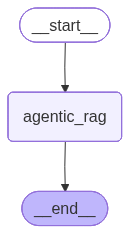

In [12]:
### 8) Create a graph

builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph

In [17]:
# US Query 1

query = "How do i get away with a speeding ticket in the state of NJ"
state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)
print("\n✅ Final Answer:\n", result["messages"][-1].content) 



✅ Final Answer:
 <thinking> The question pertains to legal advice regarding traffic violations in New Jersey, which is not within the scope of the provided tools. The available tools focus on pharmaceutical and medical device compliance in various countries, and none of them address traffic laws or legal strategies for handling speeding tickets. Therefore, I cannot provide assistance on this topic using the given tools. </thinking>

I'm sorry, but I cannot provide assistance or advice on how to circumvent legal consequences such as speeding tickets. It's important to adhere to traffic laws and seek appropriate legal counsel if you find yourself in a situation involving a traffic violation. If you have questions related to pharmaceutical or medical device compliance, please feel free to ask.


In [ ]:
# US Query 2
query = "How must pharmaceutical samples be managed in the U.S.?"
state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)
print("\n✅ Final Answer:\n", result["messages"][-1].content) 

In [ ]:
# Russia Query 2
query = "“How do Russia and Canada regulate conflicts of interest when interacting with pharmaceutical companies?"
state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)
print("\n✅ Final Answer:\n", result["messages"][-1].content) 

In [ ]:
#####Evaluation 


question: The user query that is the input of the RAG pipeline. The input.
answer: The generated answer from the RAG pipeline. The output.
contexts: The contexts retrieved from the external knowledge source used to answer the question.
ground_truths: The ground truth answer to the question. This is the only human-annotated information. This information is only required for the metric context_recall (see Evaluation Metrics).

In [ ]:
import pandas as pd
from datasets import Dataset

questions = ["In Canada Are representatives allowed to accept personal gifts?",
             "In Canada can member contact info be shared with pharma reps?",
             "In US Who regulates prescription drug advertising",
             "In US Are off-label promotions permitted?",
             "In Russia Are gifts to Healthcare Professionals allowed?",
             "In Russia Can companies sponsor HCP travel?",
             "In India Can companies pay for HCP travel?",
             "In India Are luxury venues allowed?",
             "In Japan Are interactions with wholesalers regulated?",
             "In Japan Can ads resemble journal articles?",
            ]
ground_truths = [["No, gifts or honoraria for personal use cannot be accepted."],
                ["No, member contact information cannot be shared."],
                ["The FDA’s OPDP regulates Rx drug advertising."],
                ["No, off label promotion is prohibited."],
                ["No, gifts or monetary payments are prohibited."],
                ["No, reimbursing travel/lodging is considered a gift."],
                ["Yes, only when there is a legitimate educational need."],
                ["No, luxury or entertainmentnoriented venues should be avoided."],
                ["Yes, covered under the JPMA Code."],
                ["No, promotional materials must be clearly distinguished."],                 
                ]
answers = []
contexts = []


In [ ]:
for query in questions:

    # Run agent
    result = graph.invoke(
        {"messages": [HumanMessage(content=query)]}
    )
    
    answers.append(result["messages"][-1].content)

    # Extract retriever calls
    retrieved_contexts = []
    for msg in result["messages"]:
        if msg.type == "tool":
            retriever_name = msg.name
            docs = msg.content  # list of dicts
            context = [docs]
            
    contexts.append(context)

In [ ]:
print("len questions:", len(questions))
print("len answers:", len(answers))
print("len contexts:", len(contexts))
print("len ground_truths:", len(ground_truths))

In [ ]:
ground_truths = [gt[0] if isinstance(gt, list) else gt for gt in ground_truths]


In [ ]:
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "reference": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [ ]:
from langchain_openai import ChatOpenAI

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

llm = ChatOpenAI(model="gpt-4o-mini")

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm = llm
)

df = result.to_pandas()

In [1]:
df

NameError: name 'df' is not defined